In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import pandas as pd
from scipy import signal
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
import os
from tqdm.notebook import tqdm

In [3]:
def trapezoid_impulse(t, tau, T1, T2):
    # T2 >= T1
    truncated_ramp = lambda t, T1: np.concatenate((t[:np.argmin(np.abs(t-T1))+1], 
                                                   np.zeros(len(t)-np.argmin(np.abs(t-T1))-1)))
    moving_average = lambda t, T2: np.concatenate((np.ones(np.argmin(np.abs(t-T2))+1), 
                                                   np.zeros(len(t)-np.argmin(np.abs(t-T2))-1)))
    h1, h2 = truncated_ramp(t, T1), moving_average(t, T2)
    h1_t_T2, h2_t_T1 = np.roll(truncated_ramp(t, T1), T2), np.roll(moving_average(t, T2), T1)
    h = h1 + tau*h2 + (T1-tau)*h2_t_T1 - h1_t_T2
    return h

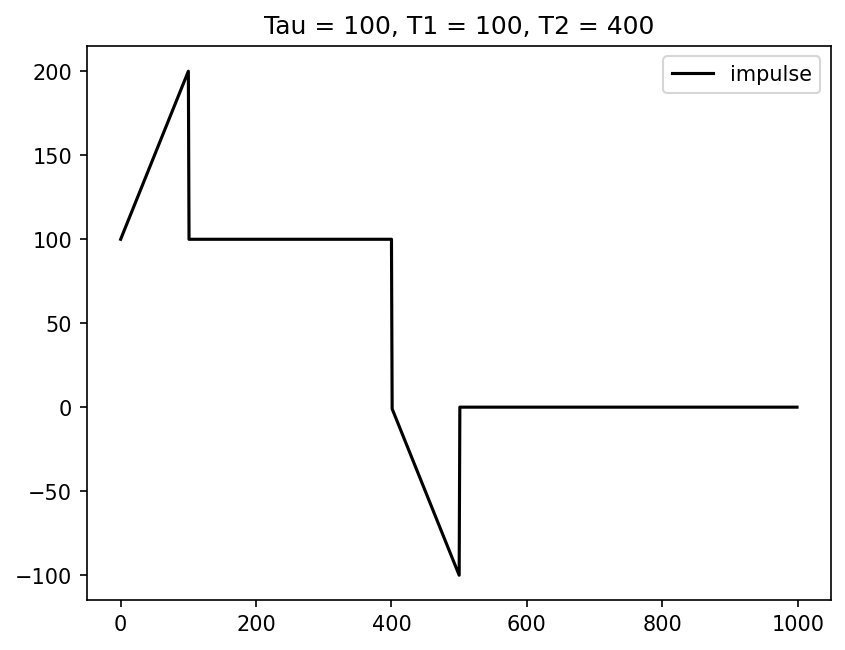

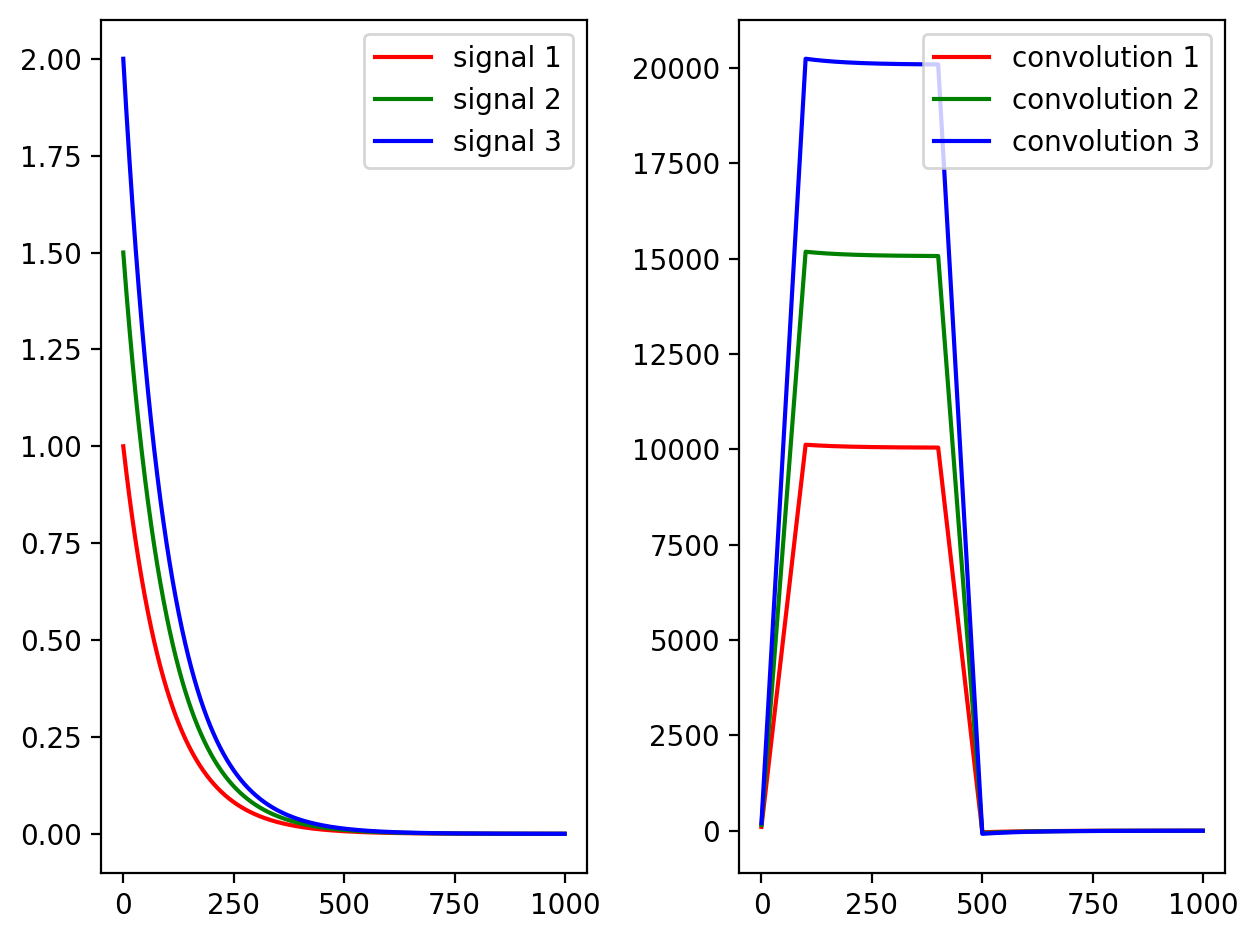

In [4]:
ln = 1000
t = np.linspace(0, 1000, ln)

test_exp = np.exp(-t/100)
test_exp2 = 1.5*np.exp(-t/100)
test_exp3 = 2*np.exp(-t/100)

tau, T1, T2 = 100, 100, 400
test = trapezoid_impulse(t, tau, T1, T2)

fig = plt.figure(dpi=150)
plt.plot(test, color='black', label='impulse')
plt.title('Tau = {}, T1 = {}, T2 = {}'.format(tau, T1, T2))
plt.legend()
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, dpi=200)
ax1.plot(test_exp, c='red', label='signal 1')
ax1.plot(test_exp2, c='green', label='signal 2')
ax1.plot(test_exp3, c='blue', label='signal 3')
ax1.legend()

ax2.plot(np.convolve(test_exp, test)[:ln], c='red', label='convolution 1')
ax2.plot(np.convolve(test_exp2, test)[:ln], c='green', label='convolution 2')
ax2.plot(np.convolve(test_exp3, test)[:ln], c='blue', label='convolution 3')
ax2.legend()
plt.tight_layout()
plt.show()